In [1]:
# load plotting library and src files
using PyPlot
include("./src/calcpml_2d.jl");
include("./src/yeeder.jl");
include("./src/fdfd.jl");
include("./src/calc_gradient.jl");

In [14]:
L = 1;
c0 = 1;
dl = 0.01;
beta = 1;
lam = 2*L*beta;
spc = L/4.0;
src = 0.5*L;
pml = 40*dl;
Pol = "Hz";
BC = [-2,-2];
NPML = [0 0 40 40];
RES = [dl/2 dl/2];

X = lam;
Y = 2*(L+spc+src+src+pml);

Nx = Int(X/dl);
Ny = Int(Y/dl);

Ne = 2;
eps_range = linspace(1.1,3,Ne);
de = 0.001
AVM_s = zeros(Complex64,Ne,1);
D_s = zeros(Ne,1);
G_list = zeros(Ne,1);
phi_list = zeros(Ne,1);

b_init = zeros(Complex64,Nx,Ny);
b_init[:,Int(ceil(Ny/2-spc/dl-L/dl-src/dl))] = 1im;
b_init[:,Int(ceil(Ny/2+spc/dl+L/dl+src/dl))] = -1im ;

MUR2 = ones(Complex64,Nx*2,Ny*2);
ER2 = ones(Complex64,Nx*2,Ny*2);

Ex0 = zeros(Complex64,Nx,Ny);
Ex_aj = zeros(Complex64,Nx,Ny);
eps = zeros(Complex64,Nx,Ny);
delta_device = zeros(Complex64,Nx,Ny);
g = 1;

b=zeros(Complex64,Nx*Ny,1);

50.0
running original
running adjoint
running direct 1
running direct 2
100.0
running original
running adjoint
running direct 1
running direct 2


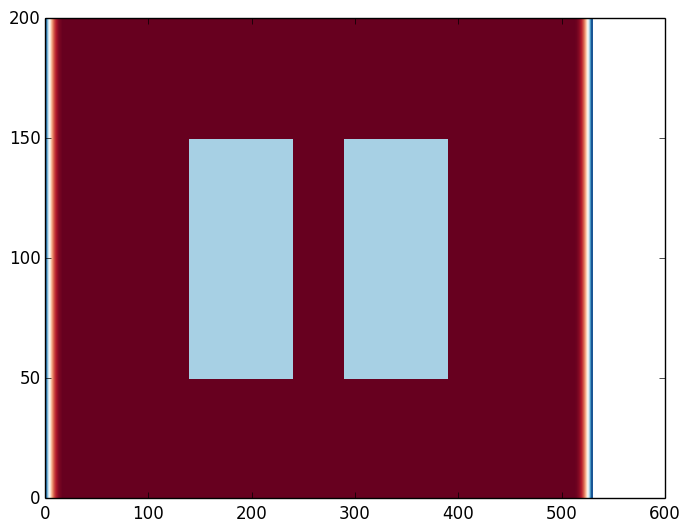

In [15]:
for i in (1:Ne)
    println(i/Ne*100.0);
    eps = eps_range[i];
    
    #original calculation    
    println("running original");
    #ER2[Int(Nx-L/dl-1):Int(Nx+L/dl+1),Int(Ny-2*spc/dl-2*L/dl-1):Int(Ny-2*spc/dl+1)] = eps/2;
    #ER2[Int(Nx-L/dl-1):Int(Nx+L/dl+1),Int(Ny+2*spc/dl-1):Int(Ny+2*spc/dl+2*L/dl+1)] = eps/2;    
    ER2[Int(Nx-L/dl):Int(Nx+L/dl),Int(Ny-2*spc/dl-2*L/dl):Int(Ny-2*spc/dl)] = eps;
    ER2[Int(Nx-L/dl):Int(Nx+L/dl),Int(Ny+2*spc/dl):Int(Ny+2*spc/dl+2*L/dl)] = eps;
    
    (Ex0,Ey0,Ez0,Hx0,Hy0,Hz0,eps_struct,DEX,DEY) = fdfd(ER2,MUR2,RES,NPML,BC,lam,Pol,b_init);
    (G,phi) = calc_gradient(Ex0,lam,dl,beta);
    G_list[i] = G;
    phi_list[i] = phi;
    
    #compute adjoint source
    (Nx,Ny) = size(Hz0);
    O = -im*lam/2/pi/c0*spdiagm(1./eps_struct[:])*DEY;
    eta = zeros(Complex64,Nx,Ny);    
    for j = (0:Nx-1)
        eta[j+1,Int(ceil(Ny/2))] = exp(2*pi*im*dl*j/lam/beta);
    end    
    eta = eta[:];
    b = -O*eta;
    
    println("running adjoint");
    (Ex_aj,Ey_aj,Ez_aj,Hx_aj,Hy_aj,Hz_aj,eps_struct,DX,DY) = fdfd(ER2,MUR2,RES,NPML,BC,lam,Pol,b);
    z = Hz_aj[:];
    y = Hz0[:];
    g = transpose(eta)*O*y;
    delta_device = (eps_struct - ones(Nx,Ny))/(eps-1);
    #delta_device = delta_device[:];
    #dAde = -1/eps/eps*((DX*spdiagm(delta_device)*spdiagm(1./eps_struct[:])*DX+DY*spdiagm(delta_device)*spdiagm(1./eps_struct[:])*DY));
    #f = float(-1/lam/beta./abs(g).*real(conj(g).*(transpose(y)*dAde*z)));
    #AVM_s[i] = f[1];
    pcolormesh(real(delta_device),cmap="RdBu")
    f = 1/lam/beta./abs(g).*(conj(g).*(2*pi/lam)^2*dl*dl*(sum(sum(delta_device[20:end-20,20:end-20].*(Ex0[20:end-20,20:end-20].*Ex_aj[20:end-20,20:end-20] + Ey0[20:end-20,20:end-20].*Ey_aj[20:end-20,20:end-20])))));
    AVM_s[i] = f[1];

    println("running direct 1");
    ER2[Int(Nx-L/dl):Int(Nx+L/dl),Int(Ny-2*spc/dl-2*L/dl):Int(Ny-2*spc/dl)] = eps+de;
    ER2[Int(Nx-L/dl):Int(Nx+L/dl),Int(Ny+2*spc/dl):Int(Ny+2*spc/dl+2*L/dl)] = eps+de;    
    (Ex_d1,Ey_d1,Ez_d1,Hx_d1,Hy_d1,Hz_d1,eps_struct,DEY) = fdfd(ER2,MUR2,RES,NPML,BC,lam,Pol,b_init);
    (G1,phi) = calc_gradient(Ex_d1,lam,dl,beta);
    
    println("running direct 2");    
    ER2[Int(Nx-L/dl):Int(Nx+L/dl),Int(Ny-2*spc/dl-2*L/dl):Int(Ny-2*spc/dl)] = eps-de;
    ER2[Int(Nx-L/dl):Int(Nx+L/dl),Int(Ny+2*spc/dl):Int(Ny+2*spc/dl+2*L/dl)] = eps-de;    
    (Ex_d2,Ey_d2,Ez_d2,Hx_d2,Hy_d2,Hz_d2,eps_struct,DEY) = fdfd(ER2,MUR2,RES,NPML,BC,lam,Pol,b_init);
    (G2,phi) = calc_gradient(Ex_d2,lam,dl,beta);
    
    D_s[i] = (G1-G2)/de;

    
    
end

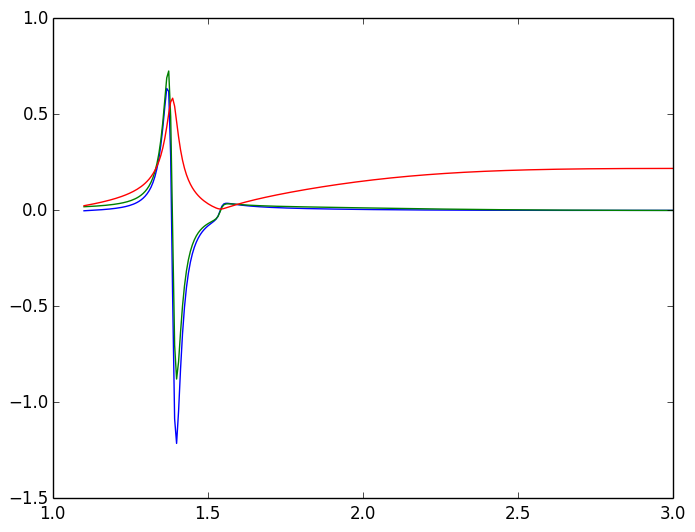

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32bf8c150>

In [227]:
plot(eps_range,-105*real(AVM_s));
plot(eps_range,D_s);
plot(eps_range,30*G_list)

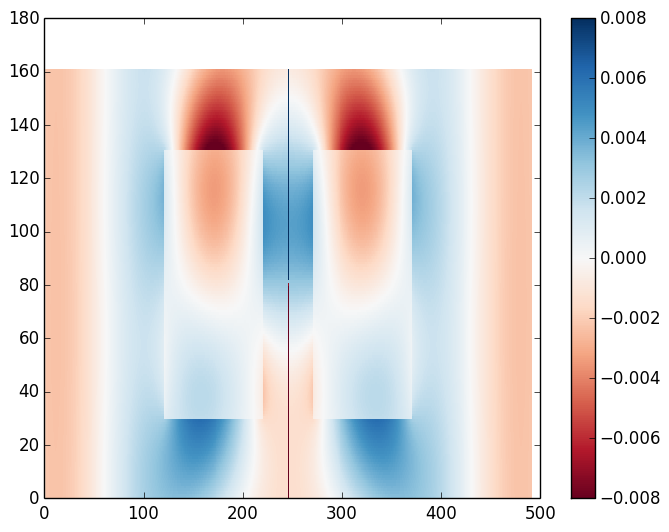

PyObject <matplotlib.colorbar.Colorbar instance at 0x323870290>

In [22]:
#pcolormesh(real(Ex_aj[:,20:end-20]).*real(Ex0[:,20:end-20]).*real(eps[:,20:end-20]),cmap="RdBu")
pcolormesh(real(Ex_aj[20:end-20,20:end-20]),cmap="RdBu",vmin=-0.008,vmax=0.008)
colorbar()

In [ ]:
xs = dl*(1:Nx);
(a,b) = size(Ex0);
#plot(xs,imag(Ex0[:,Int(b/2)]))
phi = phi_list[1];
println(phi)
plot(xs,real(Ex0[:,int(b/2)]))
plot(xs,real(Ex0[:,Int(b/2)].*exp(im*(2*pi/lam/beta*xs + phi*ones(Nx,1)))))
sum(real(Ex0[:,Int(b/2)].*exp(im*(2*pi/lam/beta*xs + phi*ones(Nx,1)))))

In [ ]:
println(eps_range)

linspace(1

In [7]:
size(1:20)


(20,)

In [125]:
AVM_s

10x1 Array{Complex{Float32},2}:
            5.8457e-5+0.000121132im
  2.88867e-5+9.70009e-5im          
  1.56035e-5+7.71818e-5im          
  1.86923e-6+7.55192e-5im          
  -1.2863e-5+7.20296e-5im          
         -0.000178203+0.000229738im
 -1.94899e-5+8.77637e-5im          
 -4.67039e-5+6.89245e-5im          
 -7.05027e-5+5.32317e-5im          
 -9.52917e-5+2.57729e-5im          

In [180]:
g

LoadError: LoadError: UndefVarError: g not defined
while loading In[180], in expression starting on line 1

In [164]:
pcolormesh(b,cmap="RdBu",vmin=0,vmax=3)
colorbar()

LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.ValueError'>
ValueError('need more than 1 value to unpack',)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/pyplot.py", line 2946, in pcolormesh
    ret = ax.pcolormesh(*args, **kwargs)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py", line 7736, in pcolormesh
    X, Y, C = self._pcolorargs('pcolormesh', *args, allmatch=allmatch)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py", line 7341, in _pcolorargs
    numRows, numCols = C.shape

while loading In[164], in expression starting on line 1

In [23]:
dl

0.01